In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
%matplotlib inline
sns.set(style='whitegrid')

# Step 2: Load the Dataset
data_path = 'data.csv'  # Replace with your dataset path
spotify_data = pd.read_csv(data_path)

# View the first few rows to understand the structure of the dataset
spotify_data.head()


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [3]:
# Check for missing values
print("Missing values per column:")
print(spotify_data.isnull().sum())

# Select features for clustering - based on musical attributes
features = spotify_data[['tempo', 'danceability', 'energy', 'loudness', 'speechiness', 
                         'acousticness', 'instrumentalness', 'liveness', 'valence']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Preview the scaled features
print("Scaled Features Preview:")
print(pd.DataFrame(scaled_features, columns=features.columns).head())


Missing values per column:
valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64
Scaled Features Preview:
      tempo  danceability    energy  loudness  speechiness  acousticness  \
0 -1.169307     -1.467013 -1.013988 -1.514237    -0.379706      1.276187   
1 -1.821180      1.598779 -0.528270 -0.170766     1.945481      0.611347   
2 -0.212404     -1.188820 -1.182122 -0.593551    -0.396297      1.220340   
3 -0.545537     -1.489722 -0.647832  0.377680    -0.387080      1.236296   
4 -0.494867     -0.677855 -1.081242  0.240788    -0.371104      1.209703   

   instrumentalness  liveness   valence  
0          2.26810

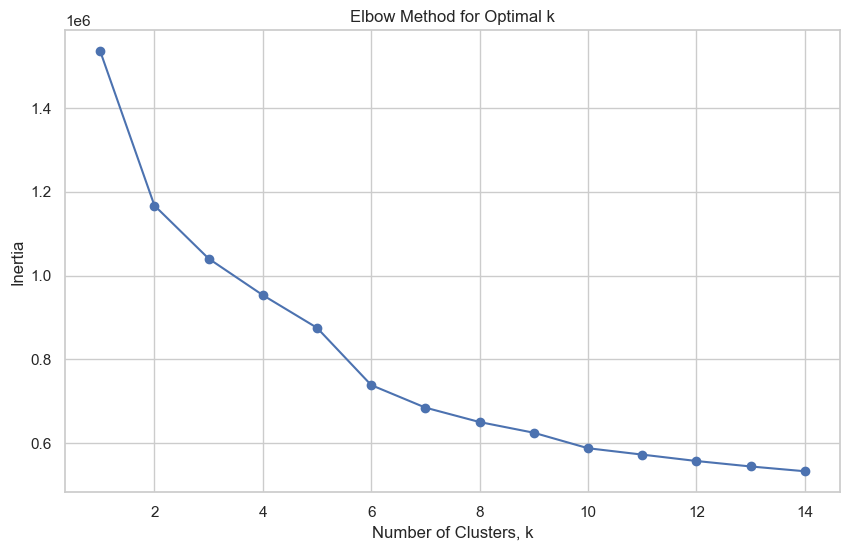

In [6]:
# Use the Elbow Method to determine optimal k
inertia = []  # Sum of squared distances of samples to their closest cluster center
k_range = range(1, 15)  # Try different cluster numbers

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the inertia values for each k to see the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [7]:
# Set the number of clusters based on the elbow method
k = 10  # Example value, adjust based on your elbow plot

# Fit the K-Means model
kmeans = KMeans(n_clusters=k, random_state=42)
spotify_data['cluster'] = kmeans.fit_predict(scaled_features)

# Check the first few entries of the data with the assigned clusters
spotify_data[['name', 'artists', 'cluster']].head()


,name,artists,cluster
0,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",3
1,Clancy Lowered the Boom,['Dennis Day'],2
2,Gati Bali,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,3
3,Danny Boy,['Frank Parker'],0
4,When Irish Eyes Are Smiling,['Phil Regan'],0


In [44]:
def recommend_songs(song_name, spotify_data, num_recommendations=5):
    """
    Recommend songs similar to the input song based on clustering and cosine similarity.
    
    Parameters:
    - song_name (str): Name of the song liked by the user.
    - spotify_data (DataFrame): The Spotify dataset with clusters assigned.
    - num_recommendations (int): Number of songs to recommend.
    
    Returns:
    - List of recommended song names.
    """
    # Locate the song in the dataset
    song = spotify_data[spotify_data['name'] == song_name]
    if song.empty:
        return "Song not found in the dataset."
    
    # Identify the cluster of the song
    cluster = song['cluster'].values[0]
    cluster_songs = spotify_data[spotify_data['cluster'] == cluster]

    # Calculate similarity within the cluster
    song_features = cluster_songs[['tempo', 'danceability', 'energy', 'loudness', 
                                   'speechiness', 'acousticness', 'instrumentalness', 
                                   'liveness', 'valence']]
    similarity_matrix = cosine_similarity(scaler.transform(song_features))

    # Get index of the input song
    song_index = cluster_songs.index[cluster_songs['name'] == song_name].tolist()[0]

    # Sort songs by similarity score, excluding the input song
    similar_songs = similarity_matrix[song_index]
    similar_songs_indices = similar_songs.argsort()[::-1][1:num_recommendations + 1]
    
    # Get song names for the recommendations
    recommended_songs = cluster_songs.iloc[similar_songs_indices]['name'].values

    return recommended_songs


In [49]:
user_song = "When We Die"
recommendations = recommend_songs(user_song, spotify_data)

print("Recommendations for the song '{}':".format(user_song))
print(recommendations)


Recommendations for the song 'When We Die':
['Lullaby to Tim - Mono; 1999 Remaster' 'Is My Living In Vain'
 "Think About It (Don't Call My Crib)" 'Own It' 'Own It']


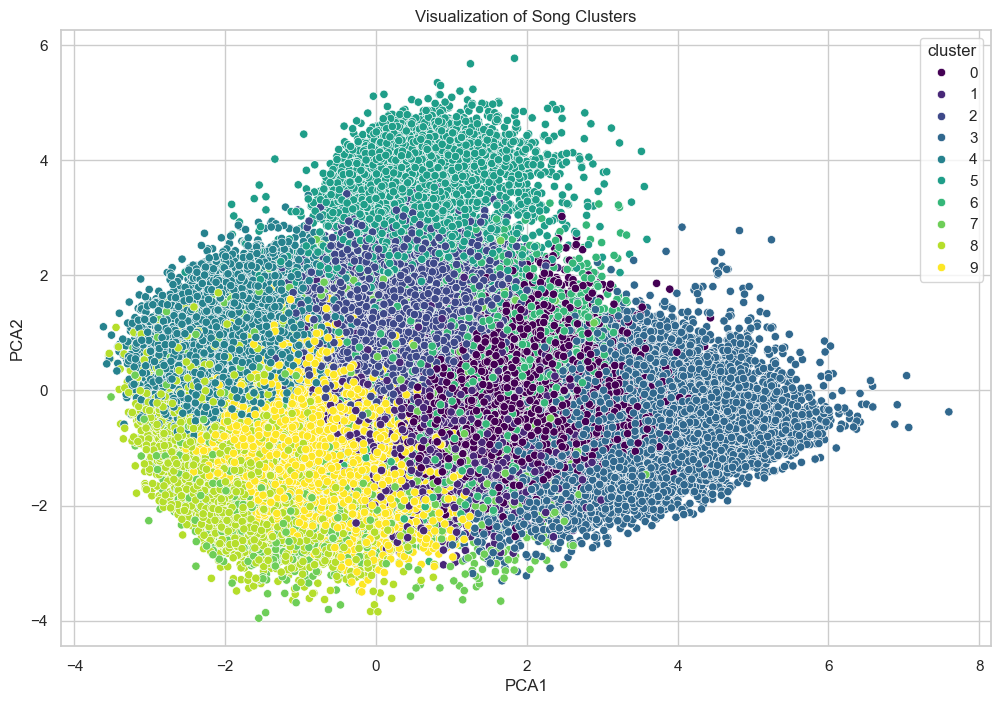

In [16]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataset
spotify_data['PCA1'] = pca_features[:, 0]
spotify_data['PCA2'] = pca_features[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=spotify_data, palette='viridis', legend='full')
plt.title('Visualization of Song Clusters')
plt.show()
